In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation


Using TensorFlow backend.


In [2]:
#base_path = os.path.join('..', '')
train_h5_path = os.path.join( 'food_c101_n10099_r32x32x1.h5')
test_h5_path = os.path.join('food_test_c101_n1000_r32x32x1.h5')
%matplotlib inline

# Load the training and validation data
We use the HDF5Matrix class to make loading the data easier

In [3]:
X_train = HDF5Matrix(train_h5_path, 'images')
y_train = HDF5Matrix(train_h5_path, 'category')
print('In Data',X_train.shape,'=>', y_train.shape)

In Data (10099, 32, 32, 1) => (10099, 101)


C:\Users\ML\Anaconda3\envs\New\lib\site-packages\keras\utils\io_utils.py:59: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(datapath)


In [4]:
X_test = HDF5Matrix(test_h5_path, 'images')
y_test = HDF5Matrix(test_h5_path, 'category')
print('In Data',X_test.shape,'=>', y_test.shape)

KeyError: "Unable to open object (object 'images' doesn't exist)"

In [ ]:
sample_imgs = 25
with h5py.File(train_h5_path, 'r') as n_file:
    total_imgs = n_file['images'].shape[0]
    read_idxs = slice(0,sample_imgs)
    im_data = n_file['images'][read_idxs]
    im_label = n_file['category'].value[read_idxs]
    label_names = [x.decode() for x in n_file['category_names'].value]
fig, m_ax = plt.subplots(5, 5, figsize = (12, 12))
for c_ax, c_label, c_img in zip(m_ax.flatten(), im_label, im_data):
    c_ax.imshow(c_img if c_img.shape[2]==3 else c_img[:,:,0], cmap = 'gray')
    c_ax.axis('off')
    c_ax.set_title(label_names[np.argmax(c_label)])

# Building the network
We build a very basic neural network for classifying the images, based on a simple Keras demo script. The network is quick to train and well suited for small datasets like the one we are using. Dropout layers have been added to prevent overfitting

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(y_test.shape[1]))
model.add(Activation('softmax'))
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

loss_history = []
model.summary()

In [ ]:
for i in range(10):
    loss_history += [model.fit(X_train, y_train,
                               validation_data=(X_test, y_test), 
                               batch_size = 256,
                               epochs = 10, shuffle="batch")]

# Examining Loss
The following function shows the loss and accuracy over the course of training. We see the training data curves in blue and the validation in red

Text(0.5, 1.0, 'Accuracy')

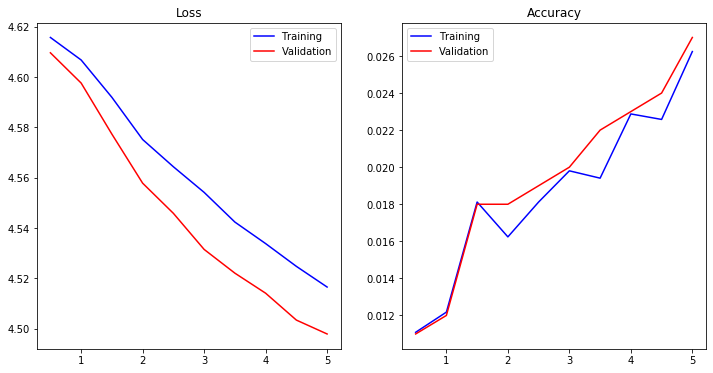

In [11]:
epich = np.cumsum(np.concatenate(
    [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
_ = ax1.plot(epich,
             np.concatenate([mh.history['loss'] for mh in loss_history]),
             'b-',
             epich, np.concatenate(
        [mh.history['val_loss'] for mh in loss_history]), 'r-')
ax1.legend(['Training', 'Validation'])
ax1.set_title('Loss')

_ = ax2.plot(epich, np.concatenate(
    [mh.history['acc'] for mh in loss_history]), 'b-',
                 epich, np.concatenate(
        [mh.history['val_acc'] for mh in loss_history]),
                 'r-')
ax2.legend(['Training', 'Validation'])
ax2.set_title('Accuracy')

# Visualizing Results
Here we show the results a small sample of validation images to see how well the predictions match the data

C:\Users\ML\Anaconda3\envs\New\lib\site-packages\ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
C:\Users\ML\Anaconda3\envs\New\lib\site-packages\ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys


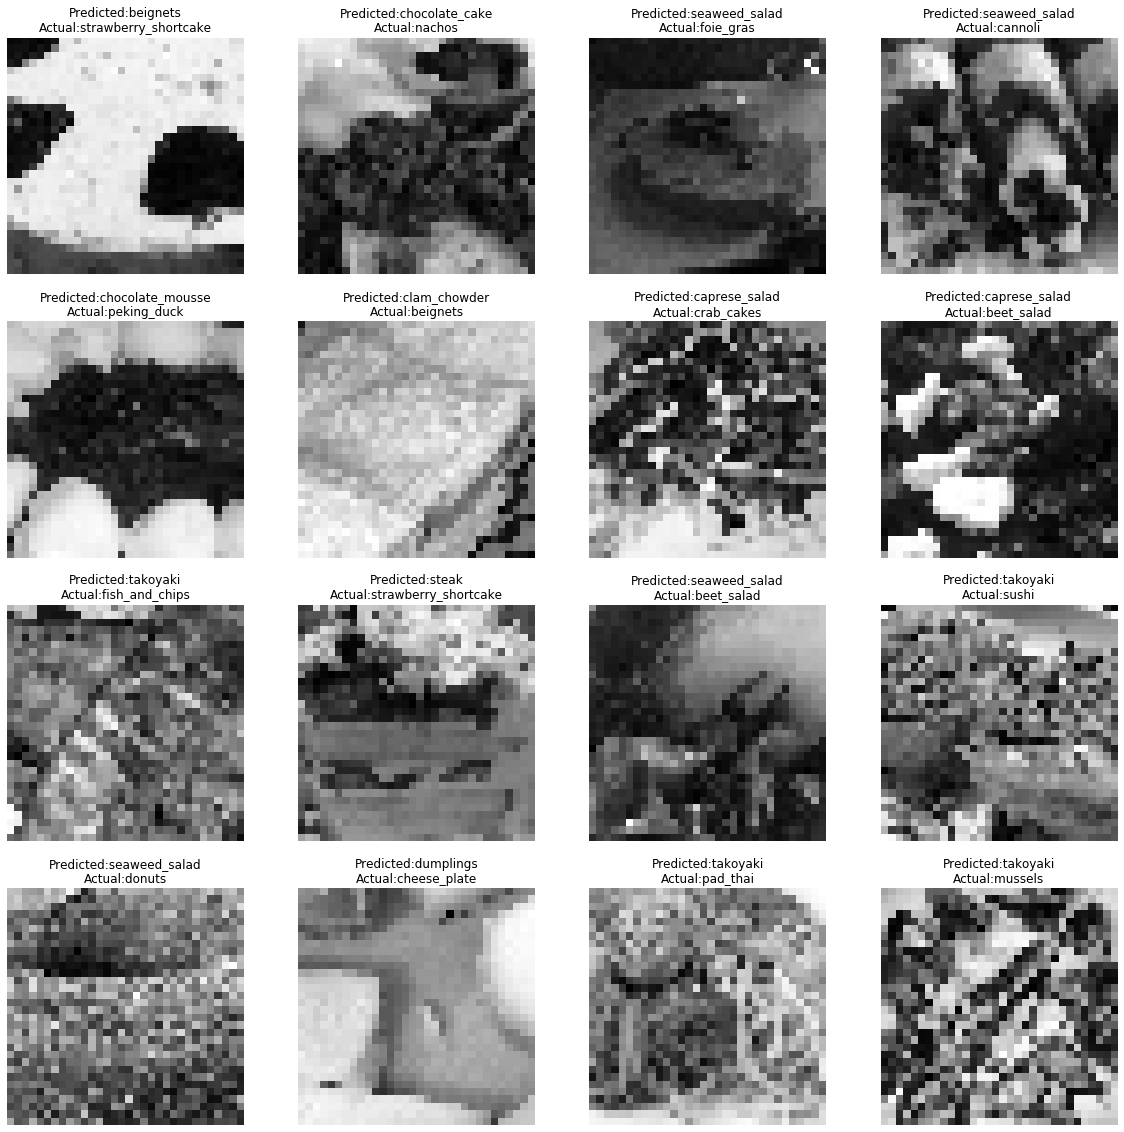

In [12]:
sample_imgs = 16
with h5py.File(test_h5_path, 'r') as n_file:
    total_imgs = n_file['images'].shape[0]
    read_idxs = slice(0,sample_imgs)
    im_data = n_file['images'][read_idxs]
    im_label = n_file['category'].value[read_idxs]
    label_names = [x.decode() for x in n_file['category_names'].value]
pred_label = model.predict(im_data)
fig, m_ax = plt.subplots(4, 4, figsize = (20, 20))
for c_ax, c_label, c_pred, c_img in zip(m_ax.flatten(), im_label, pred_label, im_data):
    c_ax.imshow(c_img if c_img.shape[2]==3 else c_img[:,:,0], cmap = 'gray')
    c_ax.axis('off')
    c_ax.set_title('Predicted:{}\nActual:{}'.format(label_names[np.argmax(c_pred)],
                                                  label_names[np.argmax(c_label)]))